In [1]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import keras.models as models
import keras.layers as layers
from keras.layers.advanced_activations import LeakyReLU, PReLU, ThresholdedReLU, ELU

np.random.seed(101)

Using TensorFlow backend.


In [2]:
df = pd.read_csv("notNiteeshData.csv")
# Dropping high sale values
df = df.drop(list(range(365,400)))
# Dropping days with 0 sale value
df = df[df['ES_POPCORN SMALL']!=0]
df = df.reset_index(drop=True)

In [3]:
def create_timestepped_data(data_frame, time_steps):
    d = []
    for i in range(time_steps):
        # chopping off the NaN's at the bottom because of shift(-i)
        # right most row will contain the latest day's sale
        d.append(data_frame.shift(-i).values[:-time_steps])
        
    # changing the dimensions from (timeSteps,dataPts,fts) to (dataPts,timeSteps,fts) 
    return np.transpose(np.array(d),(1,0,2))


In [4]:
def create_formatted_data(time_steps, num_features, df):
    data = df[['tamil','english','hindi','others','ES_POPCORN SMALL']]
    # Normalizing the values
    data_norm = (data - data.min())/(data.max() - data.min())
    # to create 3d df in the form of (dataPts,timeSteps,features)
    d = create_timestepped_data(pd.DataFrame(data_norm),time_steps)
    # choosing the first 10 timesteps(in this case) data (past)
    past = d[:,:int(time_steps/2),:]
    # reversing the future so that the farthest day comes to left and nearest day goes to right
    fut = np.flip(d[:,int(time_steps/2)+1:,:],1)
    # choosing center time step, all features but the sale value
    cur = d[:,int(time_steps/2),:-1]
    #stacking zeros for the CNN architecture
    cur = np.concatenate((cur.reshape(-1,1,4),np.zeros(shape=(cur.shape[0],1,252))),axis=-1)  
    # getting out the y val and de-normalizing it 
    y = d[:,int(time_steps/2),-1] * (data.max()[-1] - data.min()[-1]) + data.min()[-1]
    
    return past,fut,cur,y

In [5]:
def train_test_split(past,fut,cur,y):
    # 70-30 split for training and testing
    train_split = int(0.7*y.shape[0])
    # splits and sends past, current and future dfs. future_test contains 0's
    return past[:train_split], past[train_split:], fut[:train_split], np.zeros_like(past[train_split:]), cur[:train_split], cur[train_split:], y[:train_split], y[train_split:]

In [6]:
time_steps = 21
num_features = 5

In [7]:
past,fut,cur,y = create_formatted_data(time_steps, num_features, df)

In [8]:
past_train, past_test, fut_train, fut_test, cur_train, cur_test, y_train, y_test = train_test_split(past,fut,cur,y)

In [9]:
def model_build(input_shape1, input_shape2, cur_input_shape):
    
    past_inp = layers.Input(shape=(input_shape1))
    fut_inp = layers.Input(shape=(input_shape2))
    cur_inp = layers.Input(shape=(cur_input_shape))
    
    cnn_fromPast = layers.Conv1D(filters=256,kernel_size=5)(past_inp)
    #cnn1 = layers.MaxPool1D(pool_size=2)(cnn1)
    cnn_fromPast = layers.Conv1D(filters=256,kernel_size=2)(cnn_fromPast)
    cnn_fromPast = layers.Dense(256)(cnn_fromPast)
    cnn_fromPast = layers.advanced_activations.LeakyReLU(0.2)(cnn_fromPast)
    
    cnn_fromFuture = layers.Conv1D(filters=256,kernel_size=5)(fut_inp)
    #cnn2 = layers.MaxPool1D(pool_size=2)(cnn2)
    cnn_fromFuture = layers.Conv1D(filters=256,kernel_size=2)(cnn_fromFuture)
    cnn_fromFuture = layers.Dense(256)(cnn_fromFuture)
    cnn_fromFuture = layers.advanced_activations.LeakyReLU(0.2)(cnn_fromFuture)
    
    cnn_out = layers.Concatenate(axis=1)([cnn_fromPast,cnn_fromFuture])
    lstm_inp = layers.Add()([cnn_out,cur_inp])
    
    x1 = layers.LSTM(832,unroll=True, return_sequences=True)(lstm_inp)
    x1 = layers.Dense(516)(x1)
    x1 = layers.Dropout(0.2)(x1)
    x1 = layers.LSTM(832,unroll=True, return_sequences=True)(x1)
    x1 = layers.Dense(516)(x1)
    x1 = layers.Dropout(0.2)(x1)
    x1 = layers.LSTM(832,unroll=True, return_sequences=True)(x1)
    x1 = layers.Dense(256)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    lstm_out = layers.Dropout(0.2)(x1)
    
    x1 = layers.Concatenate(axis=1)([lstm_out,cnn_out])
    x1 = layers.Flatten()(x1)
    
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1024)(x1)
    x1 = layers.advanced_activations.LeakyReLU(0.2)(x1)
    x1 = layers.Dense(1)(x1)
    main_out = layers.advanced_activations.LeakyReLU(0.2)(x1)
    
    model = models.Model(inputs=[past_inp,fut_inp,cur_inp], outputs=[main_out], name='CLDNN')
    model.summary()
    model.compile(optimizer='adam',loss='mse',metrics=['mae'])
    
    return model
    
    

In [10]:
model = model_build(past.shape[1:],fut.shape[1:],cur.shape[1:])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 10, 5)         0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 10, 5)         0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 6, 256)        6656        input_1[0][0]                    
____________________________________________________________________________________________________
conv1d_3 (Conv1D)                (None, 6, 256)        6656        input_2[0][0]                    
___________________________________________________________________________________________

In [9]:
model.fit(x=[past_train,fut_train,cur_train], y=y_train, epochs=100, batch_size=32,
          validation_data=([past_test,fut_test,cur_test],y_test))

Train on 645 samples, validate on 277 samples
Epoch 1/100
645/645 [==============================] - 271s - loss: 378468.3290 - mean_absolute_error: 466.1689 - val_loss: 105618.0038 - val_mean_absolute_error: 306.6837
Epoch 2/100
645/645 [==============================] - 2s - loss: 100483.4342 - mean_absolute_error: 275.9175 - val_loss: 20037.2631 - val_mean_absolute_error: 108.3025
Epoch 3/100
645/645 [==============================] - 2s - loss: 19943.1173 - mean_absolute_error: 115.0194 - val_loss: 21364.9570 - val_mean_absolute_error: 116.1495
Epoch 4/100
645/645 [==============================] - 2s - loss: 12046.3252 - mean_absolute_error: 87.2176 - val_loss: 24797.0264 - val_mean_absolute_error: 136.2168
Epoch 5/100
645/645 [==============================] - 2s - loss: 7746.5949 - mean_absolute_error: 66.8976 - val_loss: 12031.3776 - val_mean_absolute_error: 90.9250
Epoch 6/100
645/645 [==============================] - 2s - loss: 5707.6419 - mean_absolute_error: 59.9815 - val_

645/645 [==============================] - 2s - loss: 249.7023 - mean_absolute_error: 12.1194 - val_loss: 2634.5529 - val_mean_absolute_error: 39.3399
Epoch 100/100
645/645 [==============================] - 2s - loss: 255.2421 - mean_absolute_error: 12.7550 - val_loss: 2278.5716 - val_mean_absolute_error: 36.1367


In [10]:
y_pred = model.predict([past_test, fut_test, cur_test], batch_size=32)
pred = pd.Series(y_pred.reshape((-1,)))
test = pd.Series(y_test.reshape((-1,)))

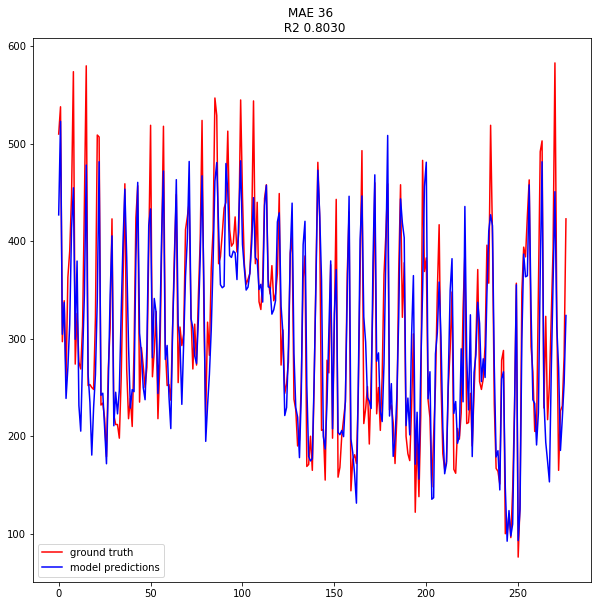

In [11]:
plt.figure(figsize=(10,10))
const = 0
plt.title("MAE %.f \n R2 %.4f"%(mean_absolute_error(test,pred+const), r2_score(test,pred+const)))
plt.plot(test.index, test, color='r', label='ground truth')
plt.plot(pred+const, color='b', label='model predictions')
plt.legend()
plt.show()